# Predicting Customer Churn in the Credit Card Industry

## Load Cleaned Data from AWS RDS
This step connects securely to the PostgreSQL database hosted on AWS RDS and retrieves the cleaned `churn_customers` dataset.


In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import getpass

# Securely fetch RDS credentials
db_user = 'postgres'
db_password = getpass.getpass("Enter your RDS password: ")
db_host = 'churndb.c9y8o80emv53.us-east-2.rds.amazonaws.com'
db_name = 'churndb'

# Connect and read data
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:5432/{db_name}?sslmode=require')
df = pd.read_sql("SELECT * FROM churn_customers", engine)

print("Data loaded from AWS RDS")
df.head()



Data loaded from AWS RDS


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,45,1,3,1,1,2,0,39,5,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1
1,818770008,49,0,5,3,0,0,0,44,6,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1
2,713982108,51,1,3,3,1,3,0,36,4,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1
3,769911858,40,0,4,1,-1,0,0,34,3,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1
4,709106358,40,1,3,0,1,2,0,21,5,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1


In [ ]:
from sqlalchemy import create_engine
import getpass

db_user = 'postgres'
db_password = getpass.getpass("Enter your RDS password: ")
db_host = 'churndb.c9y8o80emv53.us-east-2.rds.amazonaws.com'
db_name = 'churndb'
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:5432/{db_name}')
df.to_sql('churn_customers', engine, index=False, if_exists='replace')
print("Uploaded cleaned data to AWS RDS")

Uploaded cleaned data to AWS RDS


## Load All Data for Modeling (From AWS)

In [5]:
query = "SELECT * FROM churn_customers"
df = pd.read_sql(query, con=engine)
df.head()

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,45,1,3,1,1,2,0,39,5,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1
1,818770008,49,0,5,3,0,0,0,44,6,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1
2,713982108,51,1,3,3,1,3,0,36,4,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1
3,769911858,40,0,4,1,-1,0,0,34,3,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1
4,709106358,40,1,3,0,1,2,0,21,5,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1


# Churn Modeling Part 2: Model Evaluation & Comparison

### Step 1: Load Cleaned Dataset and Required Libraries
This section prepares the data and imports ML tools.

In [6]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv('../data/Credit_Card_Customers_Cleaned.csv')


### Step 2: Feature Engineering
We create new behavioral features to improve model accuracy.

In [7]:

df['Spend_per_Transaction'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
df['Monthly_Spend'] = df['Total_Trans_Amt'] / df['Months_on_book']
df['Utilization_Trend'] = df['Avg_Utilization_Ratio'] * df['Credit_Limit']
df['Activity_Ratio'] = df['Total_Ct_Chng_Q4_Q1'] * df['Total_Amt_Chng_Q4_Q1']


### Step 3: Train-Test Split and Feature Scaling
Data is split and scaled for fair training.

In [8]:

X = df.drop(columns='Churn')
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Step 4: Train Models
We train Logistic Regression, Decision Tree, and Random Forest models.

In [9]:

lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

lr.fit(X_train_scaled, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

lr_preds = lr.predict(X_test_scaled)
dt_preds = dt.predict(X_test)
rf_preds = rf.predict(X_test)


### Step 5: Evaluate Model Performance
We compare models based on accuracy, recall, and F1 score.

In [10]:

model_metrics = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_preds),
        'Recall': recall_score(y_test, lr_preds),
        'F1 Score': f1_score(y_test, lr_preds)
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test, dt_preds),
        'Recall': recall_score(y_test, dt_preds),
        'F1 Score': f1_score(y_test, dt_preds)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, rf_preds),
        'Recall': recall_score(y_test, rf_preds),
        'F1 Score': f1_score(y_test, rf_preds)
    }
}

pd.DataFrame(model_metrics).T.sort_values(by='F1 Score', ascending=False)


,Accuracy,Recall,F1 Score
Random Forest,0.961007,0.982951,0.976921
Decision Tree,0.941264,0.960611,0.964866
Logistic Regression,0.913129,0.969430,0.949338


### Step 6: Plot Feature Importances
We use Random Forest to determine which features impact churn prediction the most.

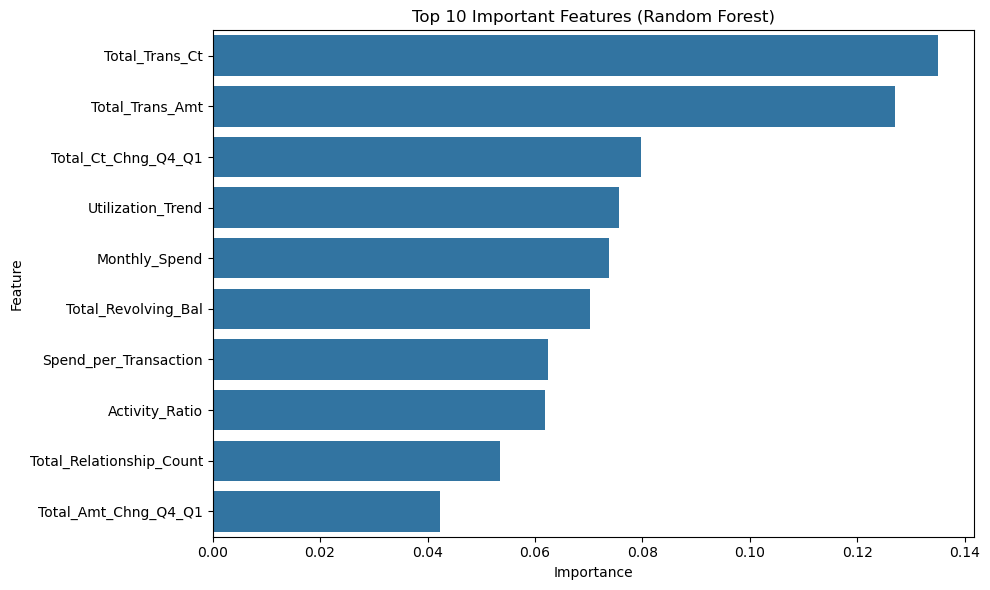

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x='Importance', y='Feature')
plt.title('Top 10 Important Features (Random Forest)')
plt.tight_layout()
plt.show()
